# Load LGMR data

In [1]:
import xarray as xr
# import numpy as np

data_dir = 'D:/VScode/Last_deglaciation/climo_ana_data'
ds_sat = xr.open_dataset(data_dir + '/ds_GMM_climo_relabeled.nc')


# Load TraCE data

Ref: He et al., 2011, SIMULATING TRANSIENT CLIMATE EVOLUTION OF THE LAST DEGLACIATION WITH CCSM3

In [9]:
import xarray as xr

def pre_process_trace_data(file_path):
    """
    Reads and preprocesses TraCE .nc data file.

    Parameters:
    file_path (str): Path to the .nc data file.

    Returns:
    xarray.Dataset: Preprocessed dataset with temperature in degrees Celsius and age in years BP.
    """
    # Import .nc data
    ds = xr.open_dataset(file_path)
    
    # Rename variables for clarity
    ds = ds.rename({'time': 'age'})
    
    # Convert 'age' from model time to years BP (before present)
    ds['age'] = ds['age'] * -1000  # Assuming 'time' is in thousands of years
    
    
    return ds

trace_all_path = "TraCE_data/trace.01-36.22000BP.cam2.ICEFRAC.22000BP_decavg_400BCE.nc"
trace_ghg_path = "TraCE_data/orginal_trace_data/b30.00_4kaDVTk.cam2.ncrcat.ann_original_backup.nc"

trace_orb_path = "TraCE_data/orginal_trace_data/b30.00_4kaDVTj.cam2.ncrcat.ann_original_backup.nc"
trace_icesheet_path = "TraCE_data/orginal_trace_data/b30.00_4kaDVTz.cam2.ncrcat.ann_original_backup.nc"
trace_fwf_path = "TraCE_data/orginal_trace_data/b30.00_4kaDVTn.cam2.ncrcat.ann_original_backup.nc"


ds_trace_all = pre_process_trace_data(trace_all_path)
ds_trace_ghg = pre_process_trace_data(trace_ghg_path)
ds_trace_orb = pre_process_trace_data(trace_orb_path)
ds_trace_icesheet = pre_process_trace_data(trace_icesheet_path)
ds_trace_fwf = pre_process_trace_data(trace_fwf_path)

ds_trace_all_sic = ds_trace_all[['ICEFRAC']]
ds_trace_ghg_sic = ds_trace_ghg[['ICEFRAC']]
ds_trace_orb_sic = ds_trace_orb[['ICEFRAC']]
ds_trace_icesheet_sic = ds_trace_icesheet[['ICEFRAC']]
ds_trace_fwf_sic = ds_trace_fwf[['ICEFRAC']]




In [10]:
import xarray as xr
import numpy as np
import pickle

def calculate_seaice_area(ds_seaice, variable_name='sic',lat_min=-90,lat_max=0):    
    # Subset dataset for latitude from -90 to 0
    ds_seaice_subset = ds_seaice.sel(lat=slice(lat_min, lat_max))

    # Constants
    R = 6371  # Earth's radius in km
    delta_theta = 2.5 / 180 * np.pi  # 2.5 degree in radians

    # Convert latitude values to radians and compute latitudinal boundaries
    lat_radians = np.radians(ds_seaice_subset['lat'].values)
    lat_boundaries = (lat_radians[:-1] + lat_radians[1:]) / 2

    # area of each grid, 
    # Ref: https://www.johndcook.com/blog/2023/02/21/sphere-grid-area/#:~:text=Area%20of%20latitude%2Flongitude%20grid&text=A%20%3D%20%CF%80%20R%C2%B2%20(sin%20%CF%86,1%20%E2%88%92%20%CE%B82)%2F180.
    A = R**2 * delta_theta * (np.sin(lat_boundaries[1:]) - np.sin(lat_boundaries[:-1]))
    A_center_lats = ds_seaice_subset['lat'].values[1:-1]

    # Reduce dataset size
    ds_seaice_subset_reduced = ds_seaice_subset.isel(lat=slice(1, -1))

    # Create an xarray DataArray for A
    A_xr = xr.DataArray(A, dims=["lat"], coords={"lat": A_center_lats})

    # Multiply sic data with A
    sic = ds_seaice_subset_reduced[variable_name]
    sic_area = sic * A_xr

    # Sum up the resulting product
    LGMR_sic_area = sic_area.sum(dim=["lat", "lon"]).values / 1e6
    # print('LGMR_sic_area:', LGMR_sic_area.shape)

    # Add age to LGMR_sic_area
    LGMR_sic_area = np.column_stack((ds_seaice_subset_reduced['age'].values, LGMR_sic_area))

    return LGMR_sic_area




In [11]:

asice_trace_all_sh = calculate_seaice_area(ds_trace_all_sic, variable_name='ICEFRAC', lat_min=-90, lat_max=0)
asice_trace_ghg_sh = calculate_seaice_area(ds_trace_ghg_sic, variable_name='ICEFRAC', lat_min=-90, lat_max=0)
asice_trace_orb_sh = calculate_seaice_area(ds_trace_orb_sic, variable_name='ICEFRAC', lat_min=-90, lat_max=0)
asice_trace_icesheet_sh = calculate_seaice_area(ds_trace_icesheet_sic, variable_name='ICEFRAC', lat_min=-90, lat_max=0)
asice_trace_fwf_sh = calculate_seaice_area(ds_trace_fwf_sic, variable_name='ICEFRAC', lat_min=-90, lat_max=0)


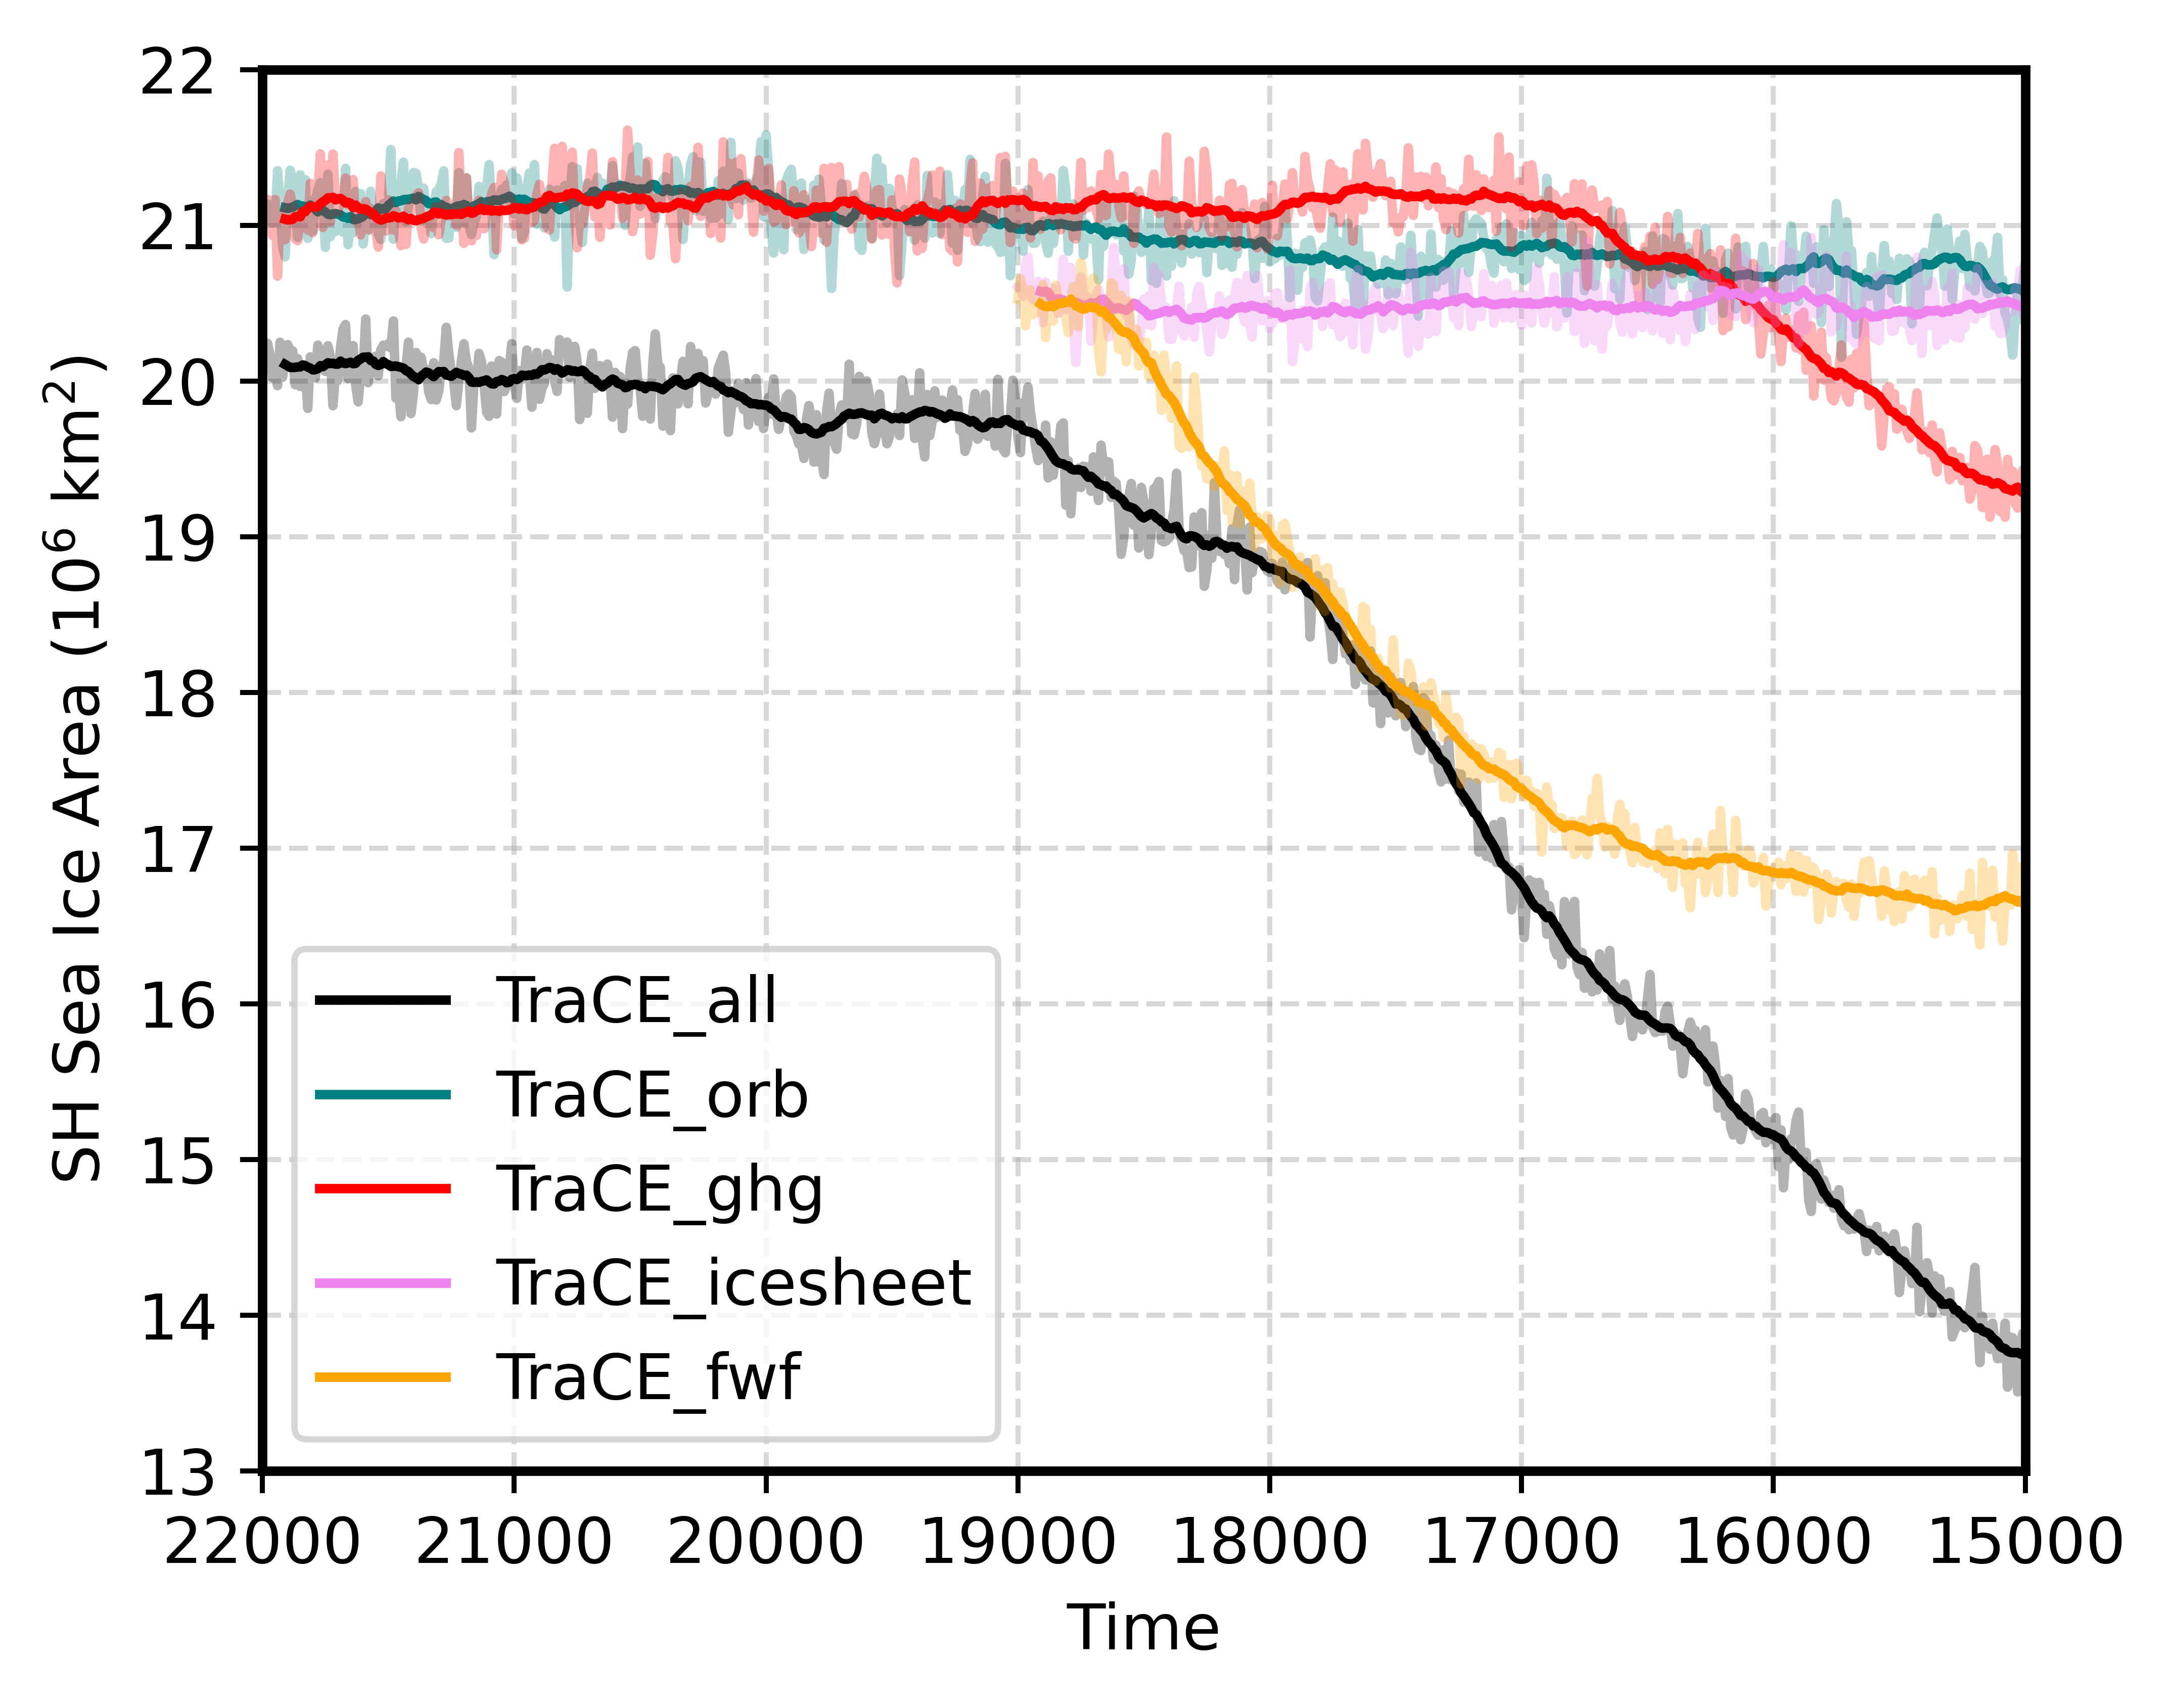

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, points=10):
    return np.convolve(data, np.ones(points)/points, mode='valid')

# Given smoothing length
smoothing_len = 20
offset_total = smoothing_len - 1  # 19 for smoothing_len=20
start_offset = offset_total // 2  # 9
end_offset = offset_total - start_offset  # 10

colors = ['k', 'red', 'teal', 'violet', 'orange']

# Extract time and data
time_all, data_all = asice_trace_all_sh[:, 0], asice_trace_all_sh[:, 1]
time_ghg, data_ghg = asice_trace_ghg_sh[:, 0], asice_trace_ghg_sh[:, 1]
time_orb, data_orb = asice_trace_orb_sh[:, 0], asice_trace_orb_sh[:, 1]
time_icesheet, data_icesheet = asice_trace_icesheet_sh[:, 0], asice_trace_icesheet_sh[:, 1]
time_fwf, data_fwf = asice_trace_fwf_sh[:, 0], asice_trace_fwf_sh[:, 1]

# Apply moving average
smoothed_all = moving_average(data_all, points=smoothing_len)
smoothed_ghg = moving_average(data_ghg, points=smoothing_len)
smoothed_orb = moving_average(data_orb, points=smoothing_len)
smoothed_icesheet = moving_average(data_icesheet, points=smoothing_len)
smoothed_fwf = moving_average(data_fwf, points=smoothing_len)

# Trim the time arrays accordingly
time_all_ma = time_all[start_offset: -end_offset]
time_ghg_ma = time_ghg[start_offset: -end_offset]
time_orb_ma = time_orb[start_offset: -end_offset]
time_icesheet_ma = time_icesheet[start_offset: -end_offset]
time_fwf_ma = time_fwf[start_offset: -end_offset]

fig, ax = plt.subplots(figsize=(5, 4), dpi=900)

# Plot original data with low alpha
ax.plot(time_all, data_all, color=colors[0], alpha=0.3)
# Plot smoothed data over the original
ax.plot(time_all_ma, smoothed_all, label='TraCE_all', color=colors[0], alpha=1.0)


ax.plot(time_orb, data_orb,  color=colors[2], alpha=0.3)
ax.plot(time_orb_ma, smoothed_orb, label='TraCE_orb', color=colors[2], alpha=1.0)

ax.plot(time_ghg, data_ghg,  color=colors[1], alpha=0.3)
ax.plot(time_ghg_ma, smoothed_ghg, label='TraCE_ghg', color=colors[1], alpha=1.0)

ax.plot(time_icesheet, data_icesheet,  color=colors[3], alpha=0.3)
ax.plot(time_icesheet_ma, smoothed_icesheet, label='TraCE_icesheet', color=colors[3], alpha=1.0)

ax.plot(time_fwf, data_fwf,  color=colors[4], alpha=0.3)
ax.plot(time_fwf_ma, smoothed_fwf, label='TraCE_fwf', color=colors[4], alpha=1.0)

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('SH Sea Ice Area ($10^6$ km$^2$)')

ax.grid(True, linestyle='--', alpha=0.5)

ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)

plt.xlim(15000, 22000)
plt.ylim(13, 22)
plt.gca().invert_xaxis()

plt.show()


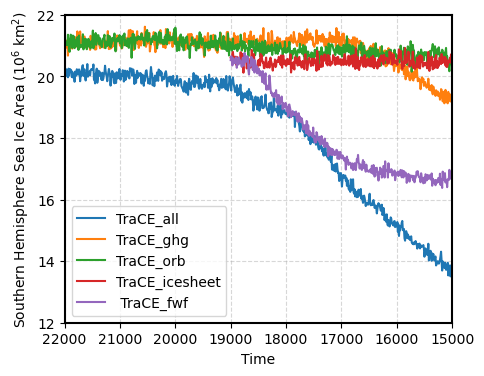

In [24]:
import matplotlib.pyplot as plt

# Extract the time and data from each time series
time_all, data_all = asice_trace_all_sh[:, 0], asice_trace_all_sh[:, 1]
time_ghg, data_ghg = asice_trace_ghg_sh[:, 0], asice_trace_ghg_sh[:, 1]
time_orb, data_orb = asice_trace_orb_sh[:, 0], asice_trace_orb_sh[:, 1]
time_icesheet, data_icesheet = asice_trace_icesheet_sh[:, 0], asice_trace_icesheet_sh[:, 1]
time_fwf, data_fwf = asice_trace_fwf_sh[:, 0], asice_trace_fwf_sh[:, 1]

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(5, 4))

# Plot each time series on the same axis
ax.plot(time_all, data_all, label='TraCE_all')
ax.plot(time_ghg, data_ghg, label='TraCE_ghg')
ax.plot(time_orb, data_orb, label='TraCE_orb')
ax.plot(time_icesheet, data_icesheet, label='TraCE_icesheet')
ax.plot(time_fwf, data_fwf, label=' TraCE_fwf')

# Add a legend
ax.legend()

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Southern Hemisphere Sea Ice Area ($10^6$ km$^2$)')
# ax.set_title('Southern Hemisphere Sea Ice Area Time Series')

# Optionally, add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# set the linewidth of the spines
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)

# set x-axis range  
plt.xlim(15000, 22000)

# set y-axis range
plt.ylim(12, 22)
# reverse the x-axis
plt.gca().invert_xaxis()

# Show the plot
plt.show()


In [ ]:
colors = ['k', 'teal', 'red', 'violet', 'orange'